In [2]:
!uv pip install matplotlib numpy

Resolved 11 packages in 1.33s                                        
Prepared 2 packages in 2.00s                                             
Installed 8 packages in 66ms                                
 + contourpy==1.3.1
 + cycler==0.12.1
 + fonttools==4.55.8
 + kiwisolver==1.4.8
 + matplotlib==3.10.0
 + numpy==2.2.2
 + pillow==11.1.0
 + pyparsing==3.2.1


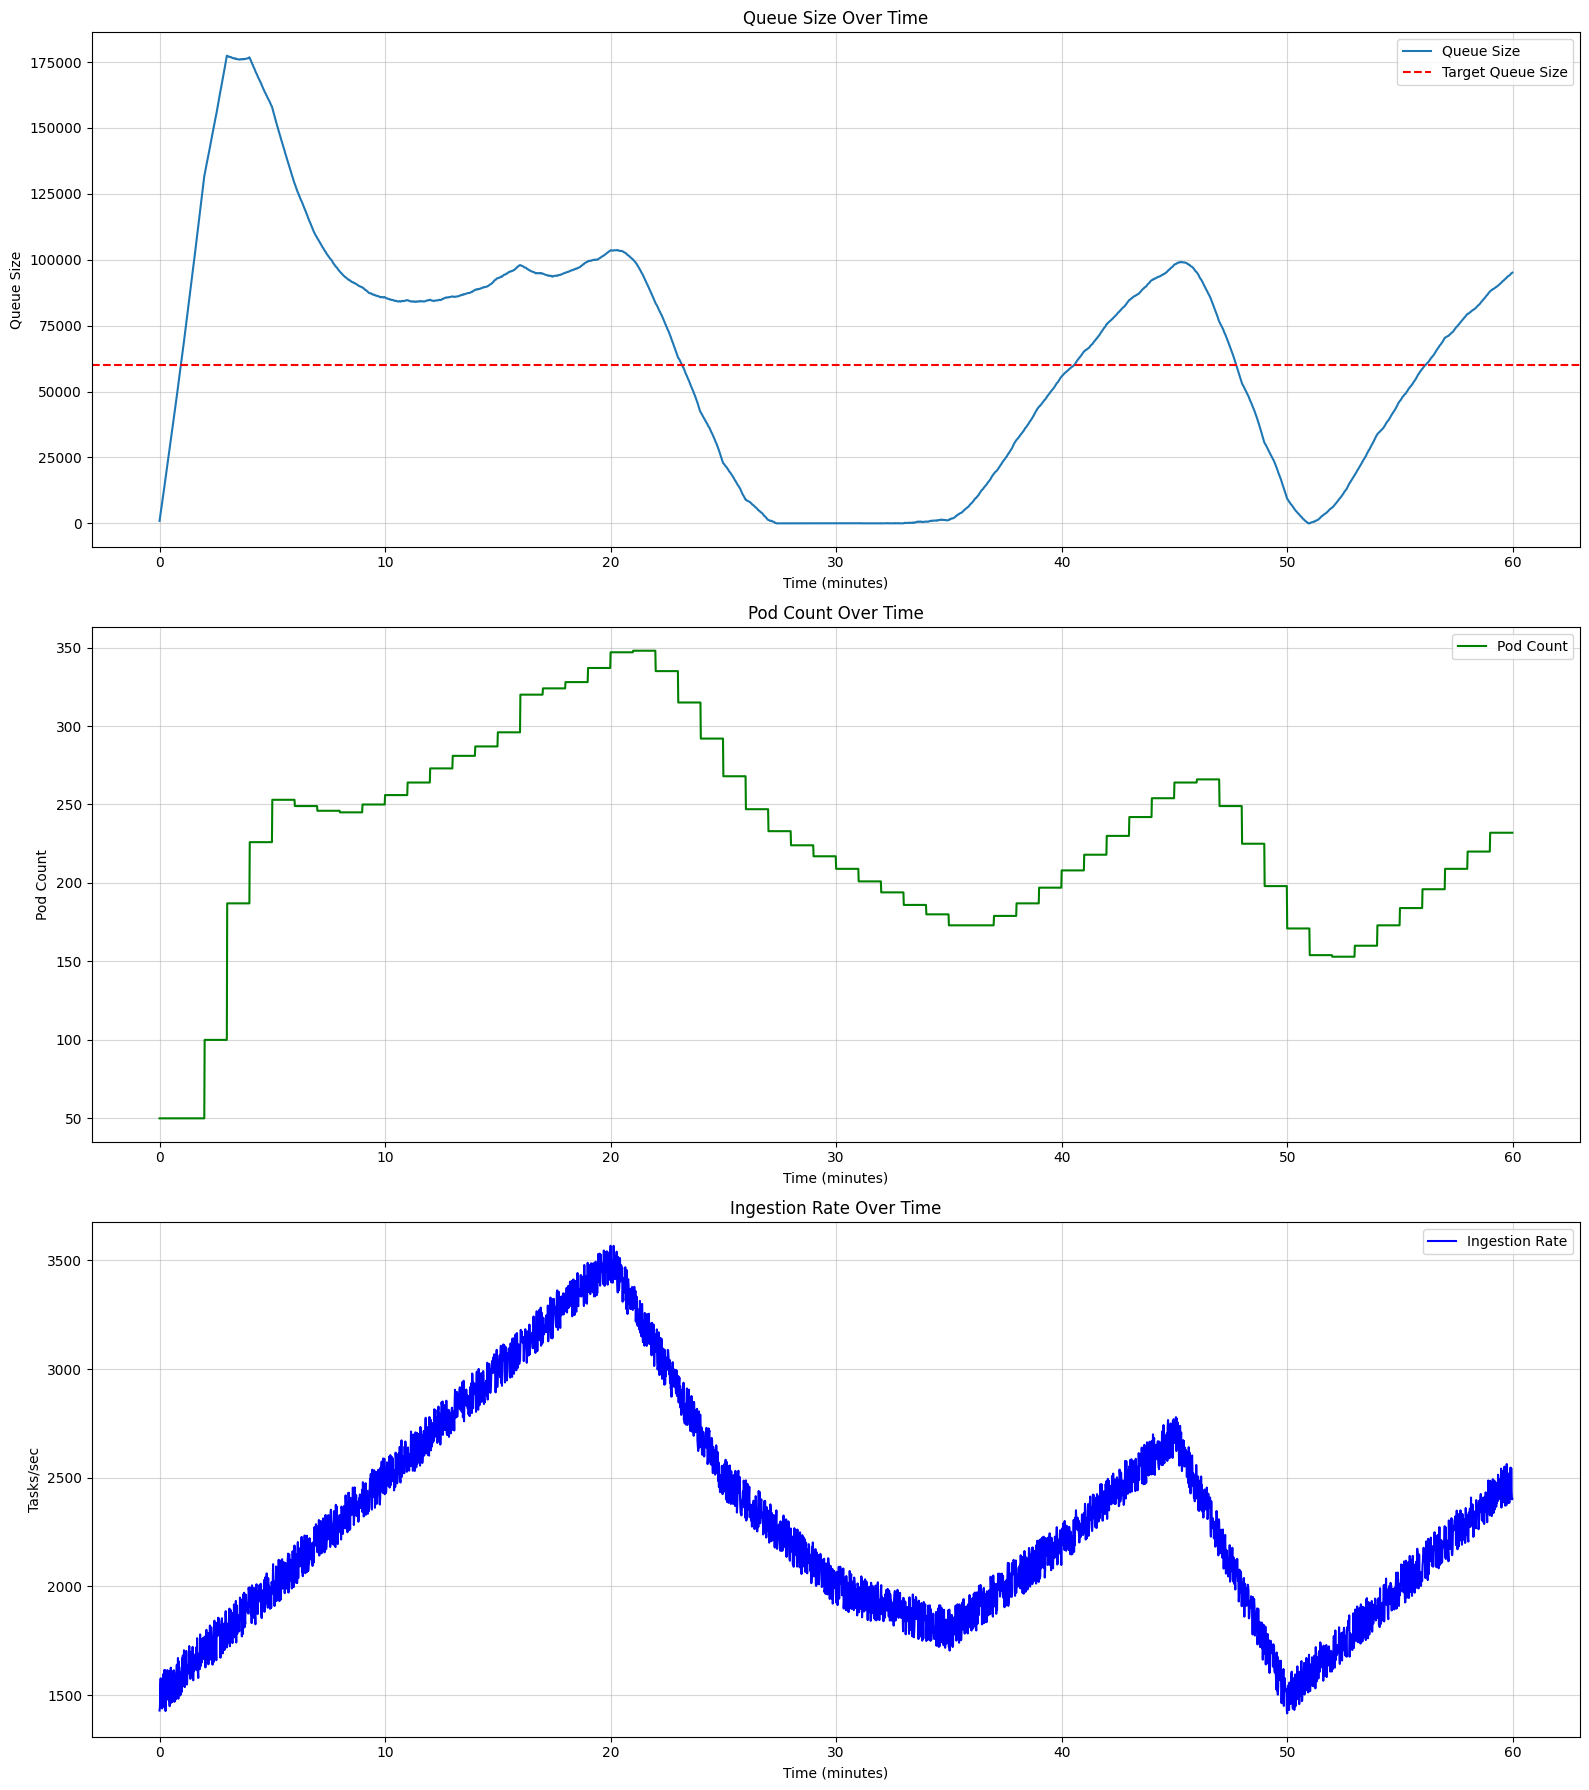

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt

# PID Implementation
class PID:
    def __init__(self, kp, ki, kd, min_out, max_out, reverse=False):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.min_output = min_out
        self.max_output = max_out
        self.reverse = reverse

        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_time = None

    def update_config(self, kp, ki, kd, min_out, max_out, reverse):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.min_output = min_out
        self.max_output = max_out
        self.reverse = reverse

    def update(self, setpoint, process_variable):
        now = time.time()
        dt = now - self.prev_time if self.prev_time else 1.0
        self.prev_time = now

        error = setpoint - process_variable if not self.reverse else process_variable - setpoint

        p = self.kp * error
        new_integral = self.integral + error * dt
        d = self.kd * ((error - self.prev_error) / dt) if dt > 0 else 0

        unclamped_output = p + self.ki * new_integral + d
        if unclamped_output > self.max_output:
            output = self.max_output
            if error < 0:
                self.integral = new_integral
        elif unclamped_output < self.min_output:
            output = self.min_output
            if error > 0:
                self.integral = new_integral
        else:
            output = unclamped_output
            self.integral = new_integral

        self.prev_error = error
        return output

# Constants
TIME_STEP = 1
SIMULATION_DURATION = 3600
REGULATION_PERIOD = 60
TARGET_QUEUE_SIZE = 60000
MIN_PODS = 50
MAX_PODS = 350

# Simulation: Ingestion Rate
def ingestion_rate(t):
    interval_duration = 5 * 60
    intervals = t // interval_duration

    base_rates = [1500, 2000, 2500, 3000, 3500, 2500, 2000, 1800, 2200, 2700]
    num_intervals = len(base_rates)

    current_base_rate = base_rates[intervals % num_intervals]
    next_base_rate = base_rates[(intervals + 1) % num_intervals]

    phase_position = (t % interval_duration) / interval_duration
    interpolated_rate = (1 - phase_position) * current_base_rate + phase_position * next_base_rate

    noise = np.random.randint(-100, 100)
    return interpolated_rate + noise

# PID Controller Setup
pid = PID(kp=0.001, ki=1, kd=0, min_out=MIN_PODS, max_out=MAX_PODS, reverse=True)

# Simulation Loop
queue_size = 0
pods = MIN_PODS

time_points = np.arange(0, SIMULATION_DURATION, TIME_STEP)
queue_sizes = []
pod_counts = []
ingestion_rates = []

for t in time_points:
    if t % REGULATION_PERIOD == 0:
        pid_output = pid.update(TARGET_QUEUE_SIZE, queue_size)
        pods = int(pid_output)

    ingestion = ingestion_rate(t)
    consumption = pods / 0.1
    queue_size += (ingestion - consumption)
    queue_size = max(0, queue_size)

    queue_sizes.append(queue_size)
    pod_counts.append(pods)
    ingestion_rates.append(ingestion)

# Plotting
plt.figure(figsize=(16, 18))

# Plot queue size
plt.subplot(3, 1, 1)
plt.plot(time_points / 60, queue_sizes, label="Queue Size", linewidth=1.5)
plt.axhline(TARGET_QUEUE_SIZE, color="r", linestyle="--", label="Target Queue Size")
plt.xlabel("Time (minutes)")
plt.ylabel("Queue Size")
plt.title("Queue Size Over Time")
plt.grid(alpha=0.5)
plt.legend()

# Plot pod count
plt.subplot(3, 1, 2)
plt.plot(time_points / 60, pod_counts, label="Pod Count", color="g", linewidth=1.5)
plt.xlabel("Time (minutes)")
plt.ylabel("Pod Count")
plt.title("Pod Count Over Time")
plt.grid(alpha=0.5)
plt.legend()

# Plot ingestion rates
plt.subplot(3, 1, 3)
plt.plot(time_points / 60, ingestion_rates, label="Ingestion Rate", color="b", linewidth=1.5)
plt.xlabel("Time (minutes)")
plt.ylabel("Tasks/sec")
plt.title("Ingestion Rate Over Time")
plt.grid(alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()
